# CSCE 421 Final Project

Jeffrey Xu  
Prof. Mortazavi  
CSCE 421  
11/11/2020  

## Abstract
Image classification has been an interesting field within AI and machine learning for many years now. There are many different machine learning models that can perform the task of image classification. Finding the best model however can be quite tricky as different models have different strengths and weaknesses. We explore the effectiveness of some unique machine learning models that can perform image classification and analyze the performance of each model on the MNIST digit dataset. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

We start by making sure the versions of our imports are correct. We can do this by using pip. 

In [238]:
!pip install torchvision==0.2.1
!pip install scikit-learn==0.23.2

Now we import all the required libraries for this project. 

In [239]:
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from torchsampler import ImbalancedDatasetSampler

We also set some initial hyperparameters. These values can change depending on how we want to implement our models. 

In [3]:
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument("-f")
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='--random-seed (default: 42)')
parser.add_argument('--nrow', type=int, default=5,
                    help='rows of example')
parser.add_argument('--ncol', type=int, default=10,
                    help='columns of example')
parser.add_argument('--n-epochs', type=int, default=25,
                   help='number of epochs')
parser.add_argument('--learning-rate', type=float, default=0.01,
                   help='learning rate')
parser.add_argument('--momentum', type=float, default=0.5, 
                   help='momentum')
parser.add_argument('--log-interval', type=int, default=10,
                   help='log interval')

args = parser.parse_args()

torch.manual_seed(args.seed)

torch.backends.cudnn.enabled = False
torch.manual_seed(args.seed)

Now we load in the training datasets that we are going to use for this project. 

In [4]:
imbalanced_linear_train_dataset = torch.load('imbalanced_linear_train_dataset.pt')
imbalanced_linear_train_loader = torch.utils.data.DataLoader(imbalanced_linear_train_dataset,
                                                             batch_size=args.batch_size, shuffle=True)

imbalanced_step_train_dataset = torch.load('imbalanced_step_train_dataset.pt')
imbalanced_step_train_loader = torch.utils.data.DataLoader(imbalanced_step_train_dataset, batch_size=args.batch_size,
                                                           shuffle=True)

In [243]:
balanced_linear_loader = torch.utils.data.DataLoader(imbalanced_linear_train_dataset, batch_size=args.batch_size, shuffle=False,
                                                     sampler=ImbalancedDatasetSampler(imbalanced_linear_train_dataset, num_samples=50000))
balanced_step_loader = torch.utils.data.DataLoader(imbalanced_step_train_dataset, batch_size=args.batch_size, shuffle=False,
                                                   sampler=ImbalancedDatasetSampler(imbalanced_step_train_dataset, num_samples=50000))

In [100]:
rus = RandomUnderSampler(random_state=args.seed)

In [7]:
X_linear = []
y_linear = []

for data in imbalanced_linear_train_dataset:
    X_linear.append(np.array(data[0]).flatten())
    y_linear.append(int(data[1]))
    
X_linear = np.array(X_linear)
y_linear = np.array(y_linear)

In [80]:
X_linear_res, y_linear_res = rus.fit_resample(X_linear, y_linear)

In [8]:
X_step = []
y_step = []

for data in imbalanced_step_train_dataset:
    X_step.append(np.array(data[0]).flatten())
    y_step.append(int(data[1]))
    
X_step = np.array(X_step)
y_step = np.array(y_step)

In [60]:
X_step_res, y_step_res = rus.fit_resample(X_step, y_step)

Now we load in the testing datasets for this project. 

In [9]:
test_dataset = torch.load('test_dataset.pt')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True)

In [11]:
X_test = []
y_test = []

for data in test_dataset:
    X_test.append(np.array(data[0]).flatten())
    y_test.append(int(data[1]))
    
X_test = np.array(X_test)
y_test = np.array(y_test)

We define a function that shows the distribution of the MNIST dataset. 

In [9]:
def show_mnist(arr, nrow=args.nrow, ncol=args.ncol, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
    plt.savefig('examples.png')

Here, we display the distribution of our MNIST dataset. 

Distribution of classes in linear imbalanced dataset:


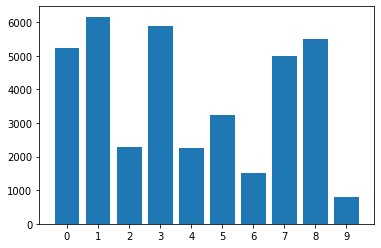

In [10]:
print('Distribution of classes in linear imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_linear_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist linear.png')
plt.show()

Distribution of classes in step imbalanced dataset:


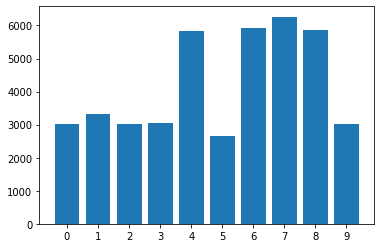

In [11]:
print('Distribution of classes in step imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_step_train_loader.dataset.train_labels, return_counts=True)
num_classes = 10
classe_labels = range(num_classes)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.savefig('dist step.png')
plt.show()

Below, we show the numbers used in each dataset. 

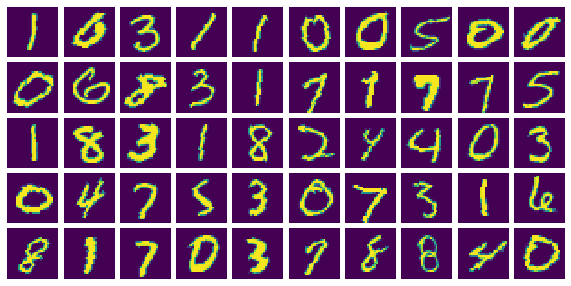

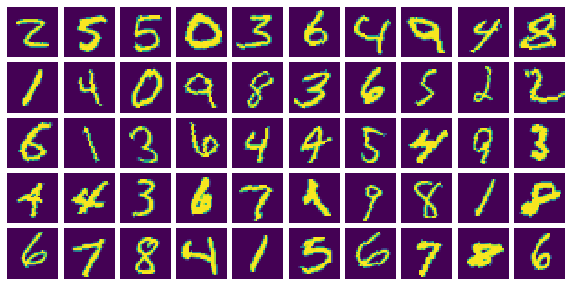

In [12]:
for data, _ in imbalanced_linear_train_loader:
    show_mnist(data)
    break

for data, _ in imbalanced_step_train_loader:
    show_mnist(data)
    break

## Logistic Regression
Our first model to test on this MNIST dataset is logistic regression. We start by importing the model in from *sklearn*.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

We will also perform Cross Validation on the training data to determine the best hyperparameters to use for our logistical model here. We also need to implement a multiclass roc score function to accurately test how well our model is doing despite the imbalance of the given dataset. 

In [13]:
def roc_auc_score_multiclass(actual_class, pred_class, average="macro"):
    # Creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        # Creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        # Marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    # Computing the average roc auc score
    total = 0
    for item in roc_auc_dict.values():
        total += item
        
    return total/len(roc_auc_dict.values())

def max_val(d):
    max = 0
    max_element = 0
    for item in d.keys():
        if d[item] > max:
            max = d[item]
            max_element = item
    return max_element

In [14]:
num_folds = 5
c_vals = [100, 10, 1.0, 0.1, 0.01]
auc_dict_linear = {100:0, 10:0, 1.0:0, 0.1:0, 0.01:0}
count = 1

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for train_index, test_index in skf.split(X_linear, y_linear):
    x_train, x_test = pd.DataFrame(X_linear).iloc[train_index], pd.DataFrame(X_linear).iloc[test_index]
    Y_train, Y_test = pd.DataFrame(y_linear).iloc[train_index], pd.DataFrame(y_linear).iloc[test_index]
    
    for c in c_vals:
        log_regressor_linear = LogisticRegression(solver="lbfgs", C=c)
        log_regressor_linear.fit(x_train, Y_train)
        
        pred = log_regressor_linear.predict(x_test)
        
        auc_dict_linear[c] += roc_auc_score_multiclass(np.array(Y_test).T[0], pred) / num_folds
    print("Fold " + str(count) + " completed")
    count += 1

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed


In [15]:
print("Best C value for linear: " + str(max_val(auc_dict_linear)))

Best C value for linear: 0.01


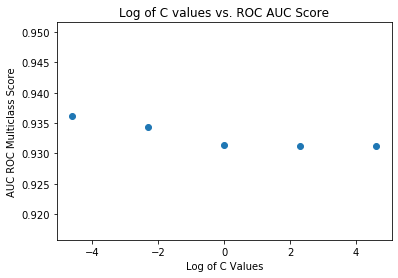

In [35]:
plt.scatter(np.log(list(auc_dict_linear.keys())), list(auc_dict_linear.values()))
plt.title('Log of C values vs. ROC AUC Score')
plt.xlabel('Log of C Values')
plt.ylabel('AUC ROC Multiclass Score')
plt.show()

Now we fit our Logistic Regression model to our data. 

In [88]:
log_model_linear = LogisticRegression(solver="lbfgs", C=max_val(auc_dict_linear)).fit(X_linear, y_linear)
log_model_linear_res = LogisticRegression(solver='lbfgs', C=max_val(auc_dict_linear)).fit(X_linear_res, y_linear_res)

In [89]:
pred = log_model_linear.predict(X_test)
pred_res = log_model_linear_res.predict(X_test)

In [90]:
print("AUC ROC multiclass score for linear dataset: " + str(roc_auc_score_multiclass(y_test, pred)))
print("AUC ROC multiclass score for linear resampled dataset: " + str(roc_auc_score_multiclass(y_test, pred_res)))

AUC ROC multiclass score for linear dataset: 0.9472371967739848
AUC ROC multiclass score for linear resampled dataset: 0.9484009823171616


Now we want to fit another separate model to the step dataset. 

In [19]:
auc_dict_step = {100:0, 10:0, 1.0:0, 0.1:0, 0.01:0}
count = 1

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for train_index, test_index in skf.split(X_step, y_step):
    x_train, x_test = pd.DataFrame(X_step).iloc[train_index], pd.DataFrame(X_step).iloc[test_index]
    Y_train, Y_test = pd.DataFrame(y_step).iloc[train_index], pd.DataFrame(y_step).iloc[test_index]
    
    for c in c_vals:
        log_regressor_step = LogisticRegression(solver="lbfgs", C=c)
        log_regressor_step.fit(x_train, Y_train)
        
        pred = log_regressor_step.predict(x_test)
        
        auc_dict_step[c] += roc_auc_score_multiclass(np.array(Y_test).T[0], pred) / num_folds
    print("Fold " + str(count) + " completed")
    count += 1

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed


In [20]:
print("Best C value for step: " + str(max_val(auc_dict_step)))

Best C value for step: 0.01


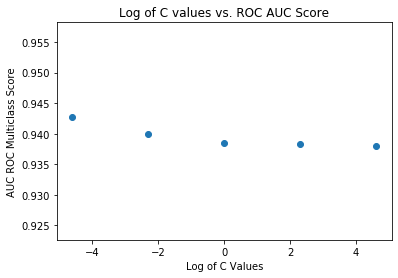

In [36]:
plt.scatter(np.log(list(auc_dict_step.keys())), list(auc_dict_step.values()))
plt.title('Log of C values vs. ROC AUC Score')
plt.xlabel('Log of C Values')
plt.ylabel('AUC ROC Multiclass Score')
plt.show()

In [91]:
log_model_step = LogisticRegression(solver="lbfgs", C=max_val(auc_dict_step)).fit(X_step, y_step)
log_model_step_res = LogisticRegression(solver='lbfgs', C=max_val(auc_dict_step)).fit(X_step_res, y_step_res)

In [92]:
pred_step = log_model_step.predict(X_test)
pred_step_res = log_model_step_res.predict(X_test)

In [93]:
print("AUC ROC multiclass score for step dataset: " + str(roc_auc_score_multiclass(y_test, pred_step)))
print("AUC ROC multiclass score for step resampled dataset: " + str(roc_auc_score_multiclass(y_test, pred_step_res)))

AUC ROC multiclass score for step dataset: 0.9521365236922357
AUC ROC multiclass score for step resampled dataset: 0.9523040187456987


## Random Forest

Now we try to fit another model to classify the MNIST digits dataset. 

In [95]:
from sklearn.ensemble import RandomForestClassifier

Now we want to perform Cross validation on our dataset to determine the best hyperparameters for our Random Forest classifier. 

In [94]:
def Cross_Validate_Models_RF(max_trees, X_train, y_train):
    # Create splitter object
    n_folds = 5
    splitter = StratifiedKFold(n_splits=n_folds, shuffle=True).split(X_train, y_train)
    
    # Performance
    gini_perf = []
    entropy_perf = []
    gini_train = []
    entropy_train = []
    for i in max_trees:
        gini_perf.append([])
        entropy_perf.append([])
        gini_train.append([])
        entropy_train.append([])
    
    fold = 1
    
    # Cross Validation
    for train_index, test_index in splitter:
        # Split training data for CV
        X_train_CV, X_test_CV = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_CV, y_test_CV = y_train.iloc[train_index].values.ravel(), y_train.iloc[test_index].values.ravel()
        
        index = 0
        
        # Iterate through all different depths
        for d in max_trees:
            model_gini = RandomForestClassifier(criterion='gini', n_estimators=d, 
                                                min_impurity_decrease=0.0, min_samples_split=2)
            model_entropy = RandomForestClassifier(criterion='entropy', n_estimators=d, 
                                                   min_impurity_decrease=0.0, min_samples_split=2)
            model_gini.fit(X_train_CV, y_train_CV)
            model_entropy.fit(X_train_CV, y_train_CV)

            pred_gini = model_gini.predict(X_test_CV)
            pred_entropy = model_entropy.predict(X_test_CV)
            
            train_gini_pred = model_gini.predict(X_train_CV)
            train_entropy_pred = model_entropy.predict(X_train_CV)

            gini_perf[index].append(roc_auc_score_multiclass(y_test_CV, pred_gini))
            entropy_perf[index].append(roc_auc_score_multiclass(y_test_CV, pred_entropy))
            
            gini_train[index].append(roc_auc_score_multiclass(y_train_CV, train_gini_pred))
            entropy_train[index].append(roc_auc_score_multiclass(y_train_CV, train_entropy_pred))
            
            index += 1
        print('Fold ' + str(fold) + ' completed')
        fold += 1
    return gini_perf, entropy_perf, gini_train, entropy_train

In [102]:
d = [100, 200, 300, 400, 500]
gini_perf_RF, entropy_perf_RF, gini_train_RF, entropy_train_RF = Cross_Validate_Models_RF(d, 
                                                                                          pd.DataFrame(X_linear), 
                                                                                          pd.DataFrame(y_linear))

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed


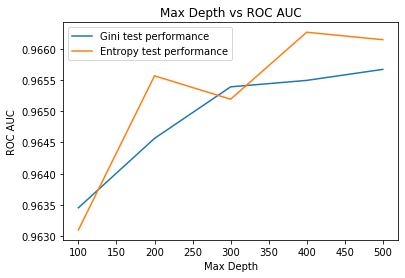

In [115]:
plt.plot(d, np.mean(gini_perf_RF, axis=1), label='Gini test performance')
plt.plot(d, np.mean(entropy_perf_RF, axis=1), label='Entropy test performance')
plt.title('Max Depth vs ROC AUC')
plt.xlabel('Max Depth')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

In [103]:
# Determine the best depth for each model
max_trees_gini_RF = d[np.argmax(np.mean(gini_perf_RF, axis=1))]
max_trees_entropy_RF = d[np.argmax(np.mean(entropy_perf_RF, axis=1))]
auc_roc_score_gini = np.max(np.mean(gini_perf_RF, axis=1))
auc_roc_score_entropy = np.max(np.mean(entropy_perf_RF, axis=1))

print('Best max-depth for the gini model: ' + str(max_trees_gini_RF) + 
      ", ROC AUC score: " + str(auc_roc_score_gini))
print('Best max-depth for the entropy model: ' + str(max_trees_entropy_RF)  + 
      ", ROC AUC score: " + str(auc_roc_score_entropy))

Best max-depth for the gini model: 500, ROC AUC score: 0.9656686702698816
Best max-depth for the entropy model: 400, ROC AUC score: 0.9662628898847269


Now that we've performed Cross Validation, we generate our model using the best hyperparameters determined from the Cross Validation run. 

In [107]:
model_type = ''
num_trees = 0
if auc_roc_score_gini > auc_roc_score_entropy:
    model_type = 'gini'
    num_trees = max_trees_gini_RF
else:
    model_type = 'entropy'
    num_trees = max_trees_entropy_RF
    
RF_model = RandomForestClassifier(criterion=model_type, n_estimators=num_trees, 
                                   min_impurity_decrease=0.0, min_samples_split=2)
RF_model_res = RandomForestClassifier(criterion=model_type, n_estimators=num_trees,
                                     min_impurity_decrease=0.0, min_samples_split=2)
RF_model.fit(X_linear, y_linear)
RF_model_res.fit(X_linear_res, y_linear_res)

RandomForestClassifier(criterion='entropy', n_estimators=400)

In [108]:
RF_pred = RF_model.predict(X_test)
RF_pred_res = RF_model_res.predict(X_test)
print('ROC Score for RF: ' + str(roc_auc_score_multiclass(y_test, RF_pred)))
print('ROC Score for RF Resampled: ' + str(roc_auc_score_multiclass(y_test, RF_pred_res)))

ROC Score for RF: 0.9729426184862197
ROC Score for RF Resampled: 0.9714230184495986


We notice a significant increase in the accuracy once we started to use the Random Forest classifier compared to the Logistic Regression classifier. Now we fit a model for the step dataset. 

In [109]:
gini_perf_RF_step, entropy_perf_RF_step, gini_train_RF_step, entropy_train_RF_step = Cross_Validate_Models_RF(d, 
                                                                                          pd.DataFrame(X_step), 
                                                                                          pd.DataFrame(y_step))

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed


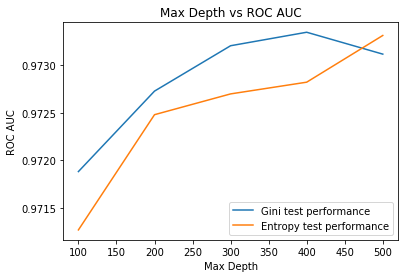

In [116]:
plt.plot(d, np.mean(gini_perf_RF_step, axis=1), label='Gini test performance')
plt.plot(d, np.mean(entropy_perf_RF_step, axis=1), label='Entropy test performance')
plt.title('Max Depth vs ROC AUC')
plt.xlabel('Max Depth')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

In [110]:
# Determine the best depth for each model
max_trees_gini_RF_step = d[np.argmax(np.mean(gini_perf_RF_step, axis=1))]
max_trees_entropy_RF_step = d[np.argmax(np.mean(entropy_perf_RF_step, axis=1))]
auc_roc_score_gini_step = np.max(np.mean(gini_perf_RF_step, axis=1))
auc_roc_score_entropy_step = np.max(np.mean(entropy_perf_RF_step, axis=1))

print('Best max-depth for the gini model: ' + str(max_trees_gini_RF_step) + 
      ", ROC AUC score: " + str(auc_roc_score_gini_step))
print('Best max-depth for the entropy model: ' + str(max_trees_entropy_RF_step)  + 
      ", ROC AUC score: " + str(auc_roc_score_entropy_step))

Best max-depth for the gini model: 400, ROC AUC score: 0.9733429079488154
Best max-depth for the entropy model: 500, ROC AUC score: 0.9733090399536415


In [111]:
model_type_step = ''
num_trees_step = 0
if auc_roc_score_gini_step > auc_roc_score_entropy_step:
    model_type_step = 'gini'
    num_trees_step = max_trees_gini_RF_step
else:
    model_type_step = 'entropy'
    num_trees_step = max_trees_entropy_RF_step
    
RF_model_step = RandomForestClassifier(criterion=model_type_step, n_estimators=num_trees_step, 
                                   min_impurity_decrease=0.0, min_samples_split=2)
RF_model_step_res = RandomForestClassifier(criterion=model_type_step, n_estimators=num_trees_step,
                                          min_impurity_decrease=0.0, min_samples_split=2)
RF_model_step.fit(X_step, y_step)
RF_model_step_res.fit(X_step_res, y_step_res)

RandomForestClassifier(n_estimators=400)

In [112]:
RF_pred_step = RF_model_step.predict(X_test)
RF_pred_step_res = RF_model_step_res.predict(X_test)
print('ROC Score for RF step: ' + str(roc_auc_score_multiclass(y_test, RF_pred_step)))
print('ROC Score for RF step resampled: ' + str(roc_auc_score_multiclass(y_test, RF_pred_step_res)))

ROC Score for RF step: 0.9792071487813313
ROC Score for RF step resampled: 0.9795475836426748


## Convolutional Neural Network

Now we want to use a Convolutional Neural Network as our model to predict digits. We will be using the PyTorch library to help generate the CNN model. We need to start by generating our CNN class object. This code was based on the template provided from https://nextjournal.com/gkoehler/pytorch-mnist. All credit for the model structure goes to the author.

In [122]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [123]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [164]:
network = CNN()
optimizer = optim.SGD(network.parameters(), lr=args.learning_rate, momentum=args.momentum)

In [165]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(imbalanced_linear_train_loader) for i in range(args.n_epochs + 1)]

In [148]:
def train(epoch, train_loader, network, optimizer):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), 
                                                                           len(train_loader.dataset), 
                                                                           100. * batch_idx / len(train_loader), 
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [149]:
def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                              correct, 
                                                                              len(test_loader.dataset),
                                                                              100. * correct / len(test_loader.dataset)))

In [166]:
test(network)
for epoch in range(1, args.n_epochs + 1):
    train(epoch, imbalanced_linear_train_loader, network, optimizer)
    test(network)


Test set: Avg. loss: 2.3165, Accuracy: 608/10000 (6%)

Train Epoch: 1 [0/37879 (0%)]	Loss: 2.345601
Train Epoch: 1 [640/37879 (2%)]	Loss: 2.295111
Train Epoch: 1 [1280/37879 (3%)]	Loss: 2.252045
Train Epoch: 1 [1920/37879 (5%)]	Loss: 2.230008
Train Epoch: 1 [2560/37879 (7%)]	Loss: 2.136305
Train Epoch: 1 [3200/37879 (8%)]	Loss: 2.130889
Train Epoch: 1 [3840/37879 (10%)]	Loss: 2.083104
Train Epoch: 1 [4480/37879 (12%)]	Loss: 1.981201
Train Epoch: 1 [5120/37879 (14%)]	Loss: 2.073714
Train Epoch: 1 [5760/37879 (15%)]	Loss: 1.699332
Train Epoch: 1 [6400/37879 (17%)]	Loss: 1.687877
Train Epoch: 1 [7040/37879 (19%)]	Loss: 1.756233
Train Epoch: 1 [7680/37879 (20%)]	Loss: 1.448253
Train Epoch: 1 [8320/37879 (22%)]	Loss: 1.553697
Train Epoch: 1 [8960/37879 (24%)]	Loss: 1.233509
Train Epoch: 1 [9600/37879 (25%)]	Loss: 1.456660
Train Epoch: 1 [10240/37879 (27%)]	Loss: 1.409914
Train Epoch: 1 [10880/37879 (29%)]	Loss: 1.222752
Train Epoch: 1 [11520/37879 (30%)]	Loss: 1.160323
Train Epoch: 1 [1216

Train Epoch: 3 [26240/37879 (69%)]	Loss: 0.363911
Train Epoch: 3 [26880/37879 (71%)]	Loss: 0.253221
Train Epoch: 3 [27520/37879 (73%)]	Loss: 0.301979
Train Epoch: 3 [28160/37879 (74%)]	Loss: 0.247773
Train Epoch: 3 [28800/37879 (76%)]	Loss: 0.186360
Train Epoch: 3 [29440/37879 (78%)]	Loss: 0.356955
Train Epoch: 3 [30080/37879 (79%)]	Loss: 0.459314
Train Epoch: 3 [30720/37879 (81%)]	Loss: 0.446502
Train Epoch: 3 [31360/37879 (83%)]	Loss: 0.304301
Train Epoch: 3 [32000/37879 (84%)]	Loss: 0.236717
Train Epoch: 3 [32640/37879 (86%)]	Loss: 0.407321
Train Epoch: 3 [33280/37879 (88%)]	Loss: 0.298918
Train Epoch: 3 [33920/37879 (90%)]	Loss: 0.432759
Train Epoch: 3 [34560/37879 (91%)]	Loss: 0.499624
Train Epoch: 3 [35200/37879 (93%)]	Loss: 0.409138
Train Epoch: 3 [35840/37879 (95%)]	Loss: 0.289726
Train Epoch: 3 [36480/37879 (96%)]	Loss: 0.190751
Train Epoch: 3 [37120/37879 (98%)]	Loss: 0.165487
Train Epoch: 3 [37760/37879 (100%)]	Loss: 0.251263

Test set: Avg. loss: 0.1620, Accuracy: 9525/1000

Train Epoch: 6 [14080/37879 (37%)]	Loss: 0.216439
Train Epoch: 6 [14720/37879 (39%)]	Loss: 0.343038
Train Epoch: 6 [15360/37879 (41%)]	Loss: 0.233961
Train Epoch: 6 [16000/37879 (42%)]	Loss: 0.304751
Train Epoch: 6 [16640/37879 (44%)]	Loss: 0.274366
Train Epoch: 6 [17280/37879 (46%)]	Loss: 0.182324
Train Epoch: 6 [17920/37879 (47%)]	Loss: 0.246447
Train Epoch: 6 [18560/37879 (49%)]	Loss: 0.282509
Train Epoch: 6 [19200/37879 (51%)]	Loss: 0.371742
Train Epoch: 6 [19840/37879 (52%)]	Loss: 0.224015
Train Epoch: 6 [20480/37879 (54%)]	Loss: 0.176263
Train Epoch: 6 [21120/37879 (56%)]	Loss: 0.159558
Train Epoch: 6 [21760/37879 (57%)]	Loss: 0.316154
Train Epoch: 6 [22400/37879 (59%)]	Loss: 0.202394
Train Epoch: 6 [23040/37879 (61%)]	Loss: 0.358025
Train Epoch: 6 [23680/37879 (62%)]	Loss: 0.370010
Train Epoch: 6 [24320/37879 (64%)]	Loss: 0.318487
Train Epoch: 6 [24960/37879 (66%)]	Loss: 0.268421
Train Epoch: 6 [25600/37879 (68%)]	Loss: 0.256029
Train Epoch: 6 [26240/37879 (69%)]	Loss: 0.406107


Train Epoch: 9 [1920/37879 (5%)]	Loss: 0.188873
Train Epoch: 9 [2560/37879 (7%)]	Loss: 0.142705
Train Epoch: 9 [3200/37879 (8%)]	Loss: 0.442560
Train Epoch: 9 [3840/37879 (10%)]	Loss: 0.118739
Train Epoch: 9 [4480/37879 (12%)]	Loss: 0.146897
Train Epoch: 9 [5120/37879 (14%)]	Loss: 0.408047
Train Epoch: 9 [5760/37879 (15%)]	Loss: 0.277183
Train Epoch: 9 [6400/37879 (17%)]	Loss: 0.142143
Train Epoch: 9 [7040/37879 (19%)]	Loss: 0.209943
Train Epoch: 9 [7680/37879 (20%)]	Loss: 0.066885
Train Epoch: 9 [8320/37879 (22%)]	Loss: 0.227555
Train Epoch: 9 [8960/37879 (24%)]	Loss: 0.129380
Train Epoch: 9 [9600/37879 (25%)]	Loss: 0.121976
Train Epoch: 9 [10240/37879 (27%)]	Loss: 0.324117
Train Epoch: 9 [10880/37879 (29%)]	Loss: 0.274922
Train Epoch: 9 [11520/37879 (30%)]	Loss: 0.258980
Train Epoch: 9 [12160/37879 (32%)]	Loss: 0.256582
Train Epoch: 9 [12800/37879 (34%)]	Loss: 0.222292
Train Epoch: 9 [13440/37879 (35%)]	Loss: 0.228815
Train Epoch: 9 [14080/37879 (37%)]	Loss: 0.095956
Train Epoch: 9 [

Train Epoch: 11 [27520/37879 (73%)]	Loss: 0.162407
Train Epoch: 11 [28160/37879 (74%)]	Loss: 0.170332
Train Epoch: 11 [28800/37879 (76%)]	Loss: 0.100192
Train Epoch: 11 [29440/37879 (78%)]	Loss: 0.217332
Train Epoch: 11 [30080/37879 (79%)]	Loss: 0.095396
Train Epoch: 11 [30720/37879 (81%)]	Loss: 0.135011
Train Epoch: 11 [31360/37879 (83%)]	Loss: 0.274817
Train Epoch: 11 [32000/37879 (84%)]	Loss: 0.144821
Train Epoch: 11 [32640/37879 (86%)]	Loss: 0.130088
Train Epoch: 11 [33280/37879 (88%)]	Loss: 0.385734
Train Epoch: 11 [33920/37879 (90%)]	Loss: 0.382191
Train Epoch: 11 [34560/37879 (91%)]	Loss: 0.288041
Train Epoch: 11 [35200/37879 (93%)]	Loss: 0.197114
Train Epoch: 11 [35840/37879 (95%)]	Loss: 0.304863
Train Epoch: 11 [36480/37879 (96%)]	Loss: 0.128666
Train Epoch: 11 [37120/37879 (98%)]	Loss: 0.081832
Train Epoch: 11 [37760/37879 (100%)]	Loss: 0.228697

Test set: Avg. loss: 0.0836, Accuracy: 9747/10000 (97%)

Train Epoch: 12 [0/37879 (0%)]	Loss: 0.409046
Train Epoch: 12 [640/37879 (

Train Epoch: 14 [13440/37879 (35%)]	Loss: 0.206650
Train Epoch: 14 [14080/37879 (37%)]	Loss: 0.178884
Train Epoch: 14 [14720/37879 (39%)]	Loss: 0.194670
Train Epoch: 14 [15360/37879 (41%)]	Loss: 0.253505
Train Epoch: 14 [16000/37879 (42%)]	Loss: 0.038090
Train Epoch: 14 [16640/37879 (44%)]	Loss: 0.202954
Train Epoch: 14 [17280/37879 (46%)]	Loss: 0.213893
Train Epoch: 14 [17920/37879 (47%)]	Loss: 0.332834
Train Epoch: 14 [18560/37879 (49%)]	Loss: 0.260653
Train Epoch: 14 [19200/37879 (51%)]	Loss: 0.214072
Train Epoch: 14 [19840/37879 (52%)]	Loss: 0.361580
Train Epoch: 14 [20480/37879 (54%)]	Loss: 0.384314
Train Epoch: 14 [21120/37879 (56%)]	Loss: 0.161803
Train Epoch: 14 [21760/37879 (57%)]	Loss: 0.238762
Train Epoch: 14 [22400/37879 (59%)]	Loss: 0.078207
Train Epoch: 14 [23040/37879 (61%)]	Loss: 0.071961
Train Epoch: 14 [23680/37879 (62%)]	Loss: 0.136692
Train Epoch: 14 [24320/37879 (64%)]	Loss: 0.159488
Train Epoch: 14 [24960/37879 (66%)]	Loss: 0.161679
Train Epoch: 14 [25600/37879 (6


Train Epoch: 17 [0/37879 (0%)]	Loss: 0.130785
Train Epoch: 17 [640/37879 (2%)]	Loss: 0.088723
Train Epoch: 17 [1280/37879 (3%)]	Loss: 0.135860
Train Epoch: 17 [1920/37879 (5%)]	Loss: 0.094261
Train Epoch: 17 [2560/37879 (7%)]	Loss: 0.049087
Train Epoch: 17 [3200/37879 (8%)]	Loss: 0.265980
Train Epoch: 17 [3840/37879 (10%)]	Loss: 0.134691
Train Epoch: 17 [4480/37879 (12%)]	Loss: 0.264535
Train Epoch: 17 [5120/37879 (14%)]	Loss: 0.328802
Train Epoch: 17 [5760/37879 (15%)]	Loss: 0.240745
Train Epoch: 17 [6400/37879 (17%)]	Loss: 0.165449
Train Epoch: 17 [7040/37879 (19%)]	Loss: 0.210558
Train Epoch: 17 [7680/37879 (20%)]	Loss: 0.214920
Train Epoch: 17 [8320/37879 (22%)]	Loss: 0.138952
Train Epoch: 17 [8960/37879 (24%)]	Loss: 0.366297
Train Epoch: 17 [9600/37879 (25%)]	Loss: 0.238203
Train Epoch: 17 [10240/37879 (27%)]	Loss: 0.272515
Train Epoch: 17 [10880/37879 (29%)]	Loss: 0.321256
Train Epoch: 17 [11520/37879 (30%)]	Loss: 0.132328
Train Epoch: 17 [12160/37879 (32%)]	Loss: 0.181885
Train

Train Epoch: 19 [24960/37879 (66%)]	Loss: 0.244466
Train Epoch: 19 [25600/37879 (68%)]	Loss: 0.223908
Train Epoch: 19 [26240/37879 (69%)]	Loss: 0.162699
Train Epoch: 19 [26880/37879 (71%)]	Loss: 0.158342
Train Epoch: 19 [27520/37879 (73%)]	Loss: 0.210654
Train Epoch: 19 [28160/37879 (74%)]	Loss: 0.093871
Train Epoch: 19 [28800/37879 (76%)]	Loss: 0.274744
Train Epoch: 19 [29440/37879 (78%)]	Loss: 0.277840
Train Epoch: 19 [30080/37879 (79%)]	Loss: 0.179087
Train Epoch: 19 [30720/37879 (81%)]	Loss: 0.131142
Train Epoch: 19 [31360/37879 (83%)]	Loss: 0.212252
Train Epoch: 19 [32000/37879 (84%)]	Loss: 0.125145
Train Epoch: 19 [32640/37879 (86%)]	Loss: 0.171673
Train Epoch: 19 [33280/37879 (88%)]	Loss: 0.122336
Train Epoch: 19 [33920/37879 (90%)]	Loss: 0.179736
Train Epoch: 19 [34560/37879 (91%)]	Loss: 0.147445
Train Epoch: 19 [35200/37879 (93%)]	Loss: 0.142144
Train Epoch: 19 [35840/37879 (95%)]	Loss: 0.193489
Train Epoch: 19 [36480/37879 (96%)]	Loss: 0.235510
Train Epoch: 19 [37120/37879 (9

Train Epoch: 22 [10880/37879 (29%)]	Loss: 0.040904
Train Epoch: 22 [11520/37879 (30%)]	Loss: 0.169788
Train Epoch: 22 [12160/37879 (32%)]	Loss: 0.466293
Train Epoch: 22 [12800/37879 (34%)]	Loss: 0.148270
Train Epoch: 22 [13440/37879 (35%)]	Loss: 0.328234
Train Epoch: 22 [14080/37879 (37%)]	Loss: 0.117161
Train Epoch: 22 [14720/37879 (39%)]	Loss: 0.249145
Train Epoch: 22 [15360/37879 (41%)]	Loss: 0.225688
Train Epoch: 22 [16000/37879 (42%)]	Loss: 0.265600
Train Epoch: 22 [16640/37879 (44%)]	Loss: 0.145503
Train Epoch: 22 [17280/37879 (46%)]	Loss: 0.305782
Train Epoch: 22 [17920/37879 (47%)]	Loss: 0.100330
Train Epoch: 22 [18560/37879 (49%)]	Loss: 0.049824
Train Epoch: 22 [19200/37879 (51%)]	Loss: 0.130675
Train Epoch: 22 [19840/37879 (52%)]	Loss: 0.147331
Train Epoch: 22 [20480/37879 (54%)]	Loss: 0.047118
Train Epoch: 22 [21120/37879 (56%)]	Loss: 0.213169
Train Epoch: 22 [21760/37879 (57%)]	Loss: 0.101922
Train Epoch: 22 [22400/37879 (59%)]	Loss: 0.162118
Train Epoch: 22 [23040/37879 (6

Train Epoch: 24 [35840/37879 (95%)]	Loss: 0.049591
Train Epoch: 24 [36480/37879 (96%)]	Loss: 0.060445
Train Epoch: 24 [37120/37879 (98%)]	Loss: 0.194052
Train Epoch: 24 [37760/37879 (100%)]	Loss: 0.087293

Test set: Avg. loss: 0.0595, Accuracy: 9824/10000 (98%)

Train Epoch: 25 [0/37879 (0%)]	Loss: 0.052112
Train Epoch: 25 [640/37879 (2%)]	Loss: 0.092733
Train Epoch: 25 [1280/37879 (3%)]	Loss: 0.102260
Train Epoch: 25 [1920/37879 (5%)]	Loss: 0.161196
Train Epoch: 25 [2560/37879 (7%)]	Loss: 0.434945
Train Epoch: 25 [3200/37879 (8%)]	Loss: 0.074811
Train Epoch: 25 [3840/37879 (10%)]	Loss: 0.224659
Train Epoch: 25 [4480/37879 (12%)]	Loss: 0.483927
Train Epoch: 25 [5120/37879 (14%)]	Loss: 0.112964
Train Epoch: 25 [5760/37879 (15%)]	Loss: 0.067910
Train Epoch: 25 [6400/37879 (17%)]	Loss: 0.082982
Train Epoch: 25 [7040/37879 (19%)]	Loss: 0.218344
Train Epoch: 25 [7680/37879 (20%)]	Loss: 0.187008
Train Epoch: 25 [8320/37879 (22%)]	Loss: 0.137249
Train Epoch: 25 [8960/37879 (24%)]	Loss: 0.2509

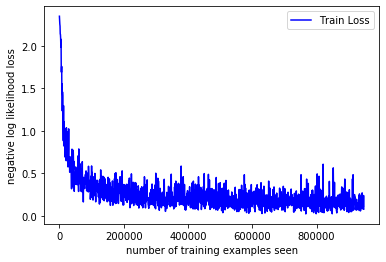

In [167]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()

In [159]:
network_step = CNN()
optimizer_step = optim.SGD(network_step.parameters(), lr=args.learning_rate, momentum=args.momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(imbalanced_step_train_loader) for i in range(args.n_epochs + 1)]

test(network_step)
for epoch in range(1, args.n_epochs + 1):
    train(epoch, imbalanced_step_train_loader, network_step, optimizer_step)
    test(network_step)


Test set: Avg. loss: 2.3158, Accuracy: 667/10000 (6%)

Train Epoch: 1 [0/41964 (0%)]	Loss: 2.332769
Train Epoch: 1 [640/41964 (2%)]	Loss: 2.325893
Train Epoch: 1 [1280/41964 (3%)]	Loss: 2.246783
Train Epoch: 1 [1920/41964 (5%)]	Loss: 2.224069
Train Epoch: 1 [2560/41964 (6%)]	Loss: 2.163418
Train Epoch: 1 [3200/41964 (8%)]	Loss: 2.188685
Train Epoch: 1 [3840/41964 (9%)]	Loss: 2.179769
Train Epoch: 1 [4480/41964 (11%)]	Loss: 2.082011
Train Epoch: 1 [5120/41964 (12%)]	Loss: 1.950175
Train Epoch: 1 [5760/41964 (14%)]	Loss: 1.863544
Train Epoch: 1 [6400/41964 (15%)]	Loss: 1.877378
Train Epoch: 1 [7040/41964 (17%)]	Loss: 1.832883
Train Epoch: 1 [7680/41964 (18%)]	Loss: 1.931687
Train Epoch: 1 [8320/41964 (20%)]	Loss: 1.769928
Train Epoch: 1 [8960/41964 (21%)]	Loss: 1.579049
Train Epoch: 1 [9600/41964 (23%)]	Loss: 1.389954
Train Epoch: 1 [10240/41964 (24%)]	Loss: 1.301887
Train Epoch: 1 [10880/41964 (26%)]	Loss: 1.504839
Train Epoch: 1 [11520/41964 (27%)]	Loss: 1.332594
Train Epoch: 1 [12160

Train Epoch: 3 [19200/41964 (46%)]	Loss: 0.329830
Train Epoch: 3 [19840/41964 (47%)]	Loss: 0.708050
Train Epoch: 3 [20480/41964 (49%)]	Loss: 0.355070
Train Epoch: 3 [21120/41964 (50%)]	Loss: 0.377308
Train Epoch: 3 [21760/41964 (52%)]	Loss: 0.373034
Train Epoch: 3 [22400/41964 (53%)]	Loss: 0.298212
Train Epoch: 3 [23040/41964 (55%)]	Loss: 0.472705
Train Epoch: 3 [23680/41964 (56%)]	Loss: 0.545766
Train Epoch: 3 [24320/41964 (58%)]	Loss: 0.226295
Train Epoch: 3 [24960/41964 (59%)]	Loss: 0.686878
Train Epoch: 3 [25600/41964 (61%)]	Loss: 0.387277
Train Epoch: 3 [26240/41964 (62%)]	Loss: 0.299693
Train Epoch: 3 [26880/41964 (64%)]	Loss: 0.572352
Train Epoch: 3 [27520/41964 (66%)]	Loss: 0.513576
Train Epoch: 3 [28160/41964 (67%)]	Loss: 0.433318
Train Epoch: 3 [28800/41964 (69%)]	Loss: 0.356469
Train Epoch: 3 [29440/41964 (70%)]	Loss: 0.568218
Train Epoch: 3 [30080/41964 (72%)]	Loss: 0.457715
Train Epoch: 3 [30720/41964 (73%)]	Loss: 0.475054
Train Epoch: 3 [31360/41964 (75%)]	Loss: 0.454727


Train Epoch: 5 [38400/41964 (91%)]	Loss: 0.212313
Train Epoch: 5 [39040/41964 (93%)]	Loss: 0.213398
Train Epoch: 5 [39680/41964 (95%)]	Loss: 0.146912
Train Epoch: 5 [40320/41964 (96%)]	Loss: 0.312016
Train Epoch: 5 [40960/41964 (98%)]	Loss: 0.285090
Train Epoch: 5 [41600/41964 (99%)]	Loss: 0.302394

Test set: Avg. loss: 0.1083, Accuracy: 9669/10000 (96%)

Train Epoch: 6 [0/41964 (0%)]	Loss: 0.276055
Train Epoch: 6 [640/41964 (2%)]	Loss: 0.385486
Train Epoch: 6 [1280/41964 (3%)]	Loss: 0.300206
Train Epoch: 6 [1920/41964 (5%)]	Loss: 0.272848
Train Epoch: 6 [2560/41964 (6%)]	Loss: 0.304404
Train Epoch: 6 [3200/41964 (8%)]	Loss: 0.322994
Train Epoch: 6 [3840/41964 (9%)]	Loss: 0.276475
Train Epoch: 6 [4480/41964 (11%)]	Loss: 0.241819
Train Epoch: 6 [5120/41964 (12%)]	Loss: 0.454435
Train Epoch: 6 [5760/41964 (14%)]	Loss: 0.350045
Train Epoch: 6 [6400/41964 (15%)]	Loss: 0.333465
Train Epoch: 6 [7040/41964 (17%)]	Loss: 0.301899
Train Epoch: 6 [7680/41964 (18%)]	Loss: 0.378330
Train Epoch: 6 [

Train Epoch: 8 [15360/41964 (37%)]	Loss: 0.155450
Train Epoch: 8 [16000/41964 (38%)]	Loss: 0.408982
Train Epoch: 8 [16640/41964 (40%)]	Loss: 0.239886
Train Epoch: 8 [17280/41964 (41%)]	Loss: 0.231563
Train Epoch: 8 [17920/41964 (43%)]	Loss: 0.284778
Train Epoch: 8 [18560/41964 (44%)]	Loss: 0.315738
Train Epoch: 8 [19200/41964 (46%)]	Loss: 0.143564
Train Epoch: 8 [19840/41964 (47%)]	Loss: 0.214584
Train Epoch: 8 [20480/41964 (49%)]	Loss: 0.174144
Train Epoch: 8 [21120/41964 (50%)]	Loss: 0.208516
Train Epoch: 8 [21760/41964 (52%)]	Loss: 0.323373
Train Epoch: 8 [22400/41964 (53%)]	Loss: 0.186340
Train Epoch: 8 [23040/41964 (55%)]	Loss: 0.143113
Train Epoch: 8 [23680/41964 (56%)]	Loss: 0.213041
Train Epoch: 8 [24320/41964 (58%)]	Loss: 0.150900
Train Epoch: 8 [24960/41964 (59%)]	Loss: 0.280769
Train Epoch: 8 [25600/41964 (61%)]	Loss: 0.238746
Train Epoch: 8 [26240/41964 (62%)]	Loss: 0.414719
Train Epoch: 8 [26880/41964 (64%)]	Loss: 0.288042
Train Epoch: 8 [27520/41964 (66%)]	Loss: 0.166418


Train Epoch: 10 [33920/41964 (81%)]	Loss: 0.165099
Train Epoch: 10 [34560/41964 (82%)]	Loss: 0.190041
Train Epoch: 10 [35200/41964 (84%)]	Loss: 0.185814
Train Epoch: 10 [35840/41964 (85%)]	Loss: 0.190343
Train Epoch: 10 [36480/41964 (87%)]	Loss: 0.484387
Train Epoch: 10 [37120/41964 (88%)]	Loss: 0.231815
Train Epoch: 10 [37760/41964 (90%)]	Loss: 0.295091
Train Epoch: 10 [38400/41964 (91%)]	Loss: 0.200864
Train Epoch: 10 [39040/41964 (93%)]	Loss: 0.111210
Train Epoch: 10 [39680/41964 (95%)]	Loss: 0.117660
Train Epoch: 10 [40320/41964 (96%)]	Loss: 0.195988
Train Epoch: 10 [40960/41964 (98%)]	Loss: 0.211053
Train Epoch: 10 [41600/41964 (99%)]	Loss: 0.571109

Test set: Avg. loss: 0.0714, Accuracy: 9782/10000 (97%)

Train Epoch: 11 [0/41964 (0%)]	Loss: 0.607227
Train Epoch: 11 [640/41964 (2%)]	Loss: 0.387090
Train Epoch: 11 [1280/41964 (3%)]	Loss: 0.287362
Train Epoch: 11 [1920/41964 (5%)]	Loss: 0.190083
Train Epoch: 11 [2560/41964 (6%)]	Loss: 0.203404
Train Epoch: 11 [3200/41964 (8%)]	Loss

Train Epoch: 13 [8320/41964 (20%)]	Loss: 0.172870
Train Epoch: 13 [8960/41964 (21%)]	Loss: 0.156747
Train Epoch: 13 [9600/41964 (23%)]	Loss: 0.344187
Train Epoch: 13 [10240/41964 (24%)]	Loss: 0.155724
Train Epoch: 13 [10880/41964 (26%)]	Loss: 0.106611
Train Epoch: 13 [11520/41964 (27%)]	Loss: 0.201126
Train Epoch: 13 [12160/41964 (29%)]	Loss: 0.132729
Train Epoch: 13 [12800/41964 (30%)]	Loss: 0.238697
Train Epoch: 13 [13440/41964 (32%)]	Loss: 0.370330
Train Epoch: 13 [14080/41964 (34%)]	Loss: 0.306336
Train Epoch: 13 [14720/41964 (35%)]	Loss: 0.266329
Train Epoch: 13 [15360/41964 (37%)]	Loss: 0.155820
Train Epoch: 13 [16000/41964 (38%)]	Loss: 0.186302
Train Epoch: 13 [16640/41964 (40%)]	Loss: 0.242960
Train Epoch: 13 [17280/41964 (41%)]	Loss: 0.448268
Train Epoch: 13 [17920/41964 (43%)]	Loss: 0.108449
Train Epoch: 13 [18560/41964 (44%)]	Loss: 0.204668
Train Epoch: 13 [19200/41964 (46%)]	Loss: 0.131398
Train Epoch: 13 [19840/41964 (47%)]	Loss: 0.311937
Train Epoch: 13 [20480/41964 (49%)

Train Epoch: 15 [25600/41964 (61%)]	Loss: 0.077132
Train Epoch: 15 [26240/41964 (62%)]	Loss: 0.290858
Train Epoch: 15 [26880/41964 (64%)]	Loss: 0.156550
Train Epoch: 15 [27520/41964 (66%)]	Loss: 0.217701
Train Epoch: 15 [28160/41964 (67%)]	Loss: 0.137225
Train Epoch: 15 [28800/41964 (69%)]	Loss: 0.388660
Train Epoch: 15 [29440/41964 (70%)]	Loss: 0.197750
Train Epoch: 15 [30080/41964 (72%)]	Loss: 0.382512
Train Epoch: 15 [30720/41964 (73%)]	Loss: 0.058871
Train Epoch: 15 [31360/41964 (75%)]	Loss: 0.304551
Train Epoch: 15 [32000/41964 (76%)]	Loss: 0.286268
Train Epoch: 15 [32640/41964 (78%)]	Loss: 0.377875
Train Epoch: 15 [33280/41964 (79%)]	Loss: 0.149874
Train Epoch: 15 [33920/41964 (81%)]	Loss: 0.293274
Train Epoch: 15 [34560/41964 (82%)]	Loss: 0.177095
Train Epoch: 15 [35200/41964 (84%)]	Loss: 0.159617
Train Epoch: 15 [35840/41964 (85%)]	Loss: 0.179791
Train Epoch: 15 [36480/41964 (87%)]	Loss: 0.263543
Train Epoch: 15 [37120/41964 (88%)]	Loss: 0.244834
Train Epoch: 15 [37760/41964 (9

Train Epoch: 18 [0/41964 (0%)]	Loss: 0.238729
Train Epoch: 18 [640/41964 (2%)]	Loss: 0.133963
Train Epoch: 18 [1280/41964 (3%)]	Loss: 0.078140
Train Epoch: 18 [1920/41964 (5%)]	Loss: 0.267953
Train Epoch: 18 [2560/41964 (6%)]	Loss: 0.124366
Train Epoch: 18 [3200/41964 (8%)]	Loss: 0.103496
Train Epoch: 18 [3840/41964 (9%)]	Loss: 0.160060
Train Epoch: 18 [4480/41964 (11%)]	Loss: 0.165553
Train Epoch: 18 [5120/41964 (12%)]	Loss: 0.370803
Train Epoch: 18 [5760/41964 (14%)]	Loss: 0.150300
Train Epoch: 18 [6400/41964 (15%)]	Loss: 0.234845
Train Epoch: 18 [7040/41964 (17%)]	Loss: 0.224151
Train Epoch: 18 [7680/41964 (18%)]	Loss: 0.198001
Train Epoch: 18 [8320/41964 (20%)]	Loss: 0.184356
Train Epoch: 18 [8960/41964 (21%)]	Loss: 0.106399
Train Epoch: 18 [9600/41964 (23%)]	Loss: 0.106918
Train Epoch: 18 [10240/41964 (24%)]	Loss: 0.181243
Train Epoch: 18 [10880/41964 (26%)]	Loss: 0.100459
Train Epoch: 18 [11520/41964 (27%)]	Loss: 0.130611
Train Epoch: 18 [12160/41964 (29%)]	Loss: 0.234366
Train E

Train Epoch: 20 [17280/41964 (41%)]	Loss: 0.176811
Train Epoch: 20 [17920/41964 (43%)]	Loss: 0.282984
Train Epoch: 20 [18560/41964 (44%)]	Loss: 0.240074
Train Epoch: 20 [19200/41964 (46%)]	Loss: 0.263255
Train Epoch: 20 [19840/41964 (47%)]	Loss: 0.166844
Train Epoch: 20 [20480/41964 (49%)]	Loss: 0.109661
Train Epoch: 20 [21120/41964 (50%)]	Loss: 0.145351
Train Epoch: 20 [21760/41964 (52%)]	Loss: 0.263272
Train Epoch: 20 [22400/41964 (53%)]	Loss: 0.218504
Train Epoch: 20 [23040/41964 (55%)]	Loss: 0.104239
Train Epoch: 20 [23680/41964 (56%)]	Loss: 0.166803
Train Epoch: 20 [24320/41964 (58%)]	Loss: 0.233019
Train Epoch: 20 [24960/41964 (59%)]	Loss: 0.279466
Train Epoch: 20 [25600/41964 (61%)]	Loss: 0.125563
Train Epoch: 20 [26240/41964 (62%)]	Loss: 0.106808
Train Epoch: 20 [26880/41964 (64%)]	Loss: 0.064227
Train Epoch: 20 [27520/41964 (66%)]	Loss: 0.235719
Train Epoch: 20 [28160/41964 (67%)]	Loss: 0.092290
Train Epoch: 20 [28800/41964 (69%)]	Loss: 0.191332
Train Epoch: 20 [29440/41964 (7

Train Epoch: 22 [34560/41964 (82%)]	Loss: 0.172318
Train Epoch: 22 [35200/41964 (84%)]	Loss: 0.132223
Train Epoch: 22 [35840/41964 (85%)]	Loss: 0.084669
Train Epoch: 22 [36480/41964 (87%)]	Loss: 0.021561
Train Epoch: 22 [37120/41964 (88%)]	Loss: 0.187013
Train Epoch: 22 [37760/41964 (90%)]	Loss: 0.214076
Train Epoch: 22 [38400/41964 (91%)]	Loss: 0.056559
Train Epoch: 22 [39040/41964 (93%)]	Loss: 0.120314
Train Epoch: 22 [39680/41964 (95%)]	Loss: 0.113818
Train Epoch: 22 [40320/41964 (96%)]	Loss: 0.075099
Train Epoch: 22 [40960/41964 (98%)]	Loss: 0.052549
Train Epoch: 22 [41600/41964 (99%)]	Loss: 0.130008

Test set: Avg. loss: 0.0504, Accuracy: 9845/10000 (98%)

Train Epoch: 23 [0/41964 (0%)]	Loss: 0.208566
Train Epoch: 23 [640/41964 (2%)]	Loss: 0.120657
Train Epoch: 23 [1280/41964 (3%)]	Loss: 0.104459
Train Epoch: 23 [1920/41964 (5%)]	Loss: 0.119493
Train Epoch: 23 [2560/41964 (6%)]	Loss: 0.243926
Train Epoch: 23 [3200/41964 (8%)]	Loss: 0.182833
Train Epoch: 23 [3840/41964 (9%)]	Loss: 

Train Epoch: 25 [8960/41964 (21%)]	Loss: 0.064642
Train Epoch: 25 [9600/41964 (23%)]	Loss: 0.107187
Train Epoch: 25 [10240/41964 (24%)]	Loss: 0.262961
Train Epoch: 25 [10880/41964 (26%)]	Loss: 0.222839
Train Epoch: 25 [11520/41964 (27%)]	Loss: 0.237436
Train Epoch: 25 [12160/41964 (29%)]	Loss: 0.231805
Train Epoch: 25 [12800/41964 (30%)]	Loss: 0.188491
Train Epoch: 25 [13440/41964 (32%)]	Loss: 0.220252
Train Epoch: 25 [14080/41964 (34%)]	Loss: 0.227819
Train Epoch: 25 [14720/41964 (35%)]	Loss: 0.164027
Train Epoch: 25 [15360/41964 (37%)]	Loss: 0.269662
Train Epoch: 25 [16000/41964 (38%)]	Loss: 0.066166
Train Epoch: 25 [16640/41964 (40%)]	Loss: 0.273509
Train Epoch: 25 [17280/41964 (41%)]	Loss: 0.159596
Train Epoch: 25 [17920/41964 (43%)]	Loss: 0.237173
Train Epoch: 25 [18560/41964 (44%)]	Loss: 0.190682
Train Epoch: 25 [19200/41964 (46%)]	Loss: 0.222364
Train Epoch: 25 [19840/41964 (47%)]	Loss: 0.165764
Train Epoch: 25 [20480/41964 (49%)]	Loss: 0.136408
Train Epoch: 25 [21120/41964 (50%

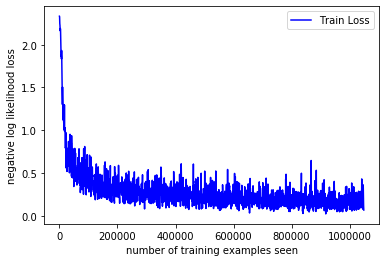

In [160]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()

In [247]:
network_balanced_linear = CNN()
optimizer_balanced_linear = optim.SGD(network_balanced_linear.parameters(), lr=args.learning_rate, momentum=args.momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(balanced_linear_loader) for i in range(args.n_epochs + 1)]

test(network_balanced_linear)
for epoch in range(1, args.n_epochs + 1):
    train(epoch, balanced_linear_loader, network_balanced_linear, optimizer_balanced_linear)
    test(network_balanced_linear)


Test set: Avg. loss: 2.3121, Accuracy: 1289/10000 (12%)

Train Epoch: 1 [0/37879 (0%)]	Loss: 2.346985
Train Epoch: 1 [640/37879 (1%)]	Loss: 2.294845
Train Epoch: 1 [1280/37879 (3%)]	Loss: 2.331121
Train Epoch: 1 [1920/37879 (4%)]	Loss: 2.283385
Train Epoch: 1 [2560/37879 (5%)]	Loss: 2.276864
Train Epoch: 1 [3200/37879 (6%)]	Loss: 2.279913
Train Epoch: 1 [3840/37879 (8%)]	Loss: 2.269794
Train Epoch: 1 [4480/37879 (9%)]	Loss: 2.191928
Train Epoch: 1 [5120/37879 (10%)]	Loss: 2.180579
Train Epoch: 1 [5760/37879 (12%)]	Loss: 2.229791
Train Epoch: 1 [6400/37879 (13%)]	Loss: 2.052692
Train Epoch: 1 [7040/37879 (14%)]	Loss: 2.088785
Train Epoch: 1 [7680/37879 (15%)]	Loss: 1.934912
Train Epoch: 1 [8320/37879 (17%)]	Loss: 1.892515
Train Epoch: 1 [8960/37879 (18%)]	Loss: 1.807242
Train Epoch: 1 [9600/37879 (19%)]	Loss: 1.595693
Train Epoch: 1 [10240/37879 (20%)]	Loss: 1.638608
Train Epoch: 1 [10880/37879 (22%)]	Loss: 1.672789
Train Epoch: 1 [11520/37879 (23%)]	Loss: 1.482107
Train Epoch: 1 [1216

Train Epoch: 3 [1920/37879 (4%)]	Loss: 0.367047
Train Epoch: 3 [2560/37879 (5%)]	Loss: 0.595592
Train Epoch: 3 [3200/37879 (6%)]	Loss: 0.337922
Train Epoch: 3 [3840/37879 (8%)]	Loss: 0.478347
Train Epoch: 3 [4480/37879 (9%)]	Loss: 0.625845
Train Epoch: 3 [5120/37879 (10%)]	Loss: 0.437738
Train Epoch: 3 [5760/37879 (12%)]	Loss: 0.478077
Train Epoch: 3 [6400/37879 (13%)]	Loss: 0.350850
Train Epoch: 3 [7040/37879 (14%)]	Loss: 0.385447
Train Epoch: 3 [7680/37879 (15%)]	Loss: 0.224056
Train Epoch: 3 [8320/37879 (17%)]	Loss: 0.300122
Train Epoch: 3 [8960/37879 (18%)]	Loss: 0.452803
Train Epoch: 3 [9600/37879 (19%)]	Loss: 0.510868
Train Epoch: 3 [10240/37879 (20%)]	Loss: 0.307067
Train Epoch: 3 [10880/37879 (22%)]	Loss: 0.526432
Train Epoch: 3 [11520/37879 (23%)]	Loss: 0.284303
Train Epoch: 3 [12160/37879 (24%)]	Loss: 0.649078
Train Epoch: 3 [12800/37879 (26%)]	Loss: 0.543617
Train Epoch: 3 [13440/37879 (27%)]	Loss: 0.275886
Train Epoch: 3 [14080/37879 (28%)]	Loss: 0.361558
Train Epoch: 3 [14

Train Epoch: 5 [4480/37879 (9%)]	Loss: 0.456869
Train Epoch: 5 [5120/37879 (10%)]	Loss: 0.269395
Train Epoch: 5 [5760/37879 (12%)]	Loss: 0.214313
Train Epoch: 5 [6400/37879 (13%)]	Loss: 0.480869
Train Epoch: 5 [7040/37879 (14%)]	Loss: 0.245320
Train Epoch: 5 [7680/37879 (15%)]	Loss: 0.564368
Train Epoch: 5 [8320/37879 (17%)]	Loss: 0.209896
Train Epoch: 5 [8960/37879 (18%)]	Loss: 0.353347
Train Epoch: 5 [9600/37879 (19%)]	Loss: 0.259509
Train Epoch: 5 [10240/37879 (20%)]	Loss: 0.105767
Train Epoch: 5 [10880/37879 (22%)]	Loss: 0.462111
Train Epoch: 5 [11520/37879 (23%)]	Loss: 0.391994
Train Epoch: 5 [12160/37879 (24%)]	Loss: 0.324591
Train Epoch: 5 [12800/37879 (26%)]	Loss: 0.394388
Train Epoch: 5 [13440/37879 (27%)]	Loss: 0.387710
Train Epoch: 5 [14080/37879 (28%)]	Loss: 0.321305
Train Epoch: 5 [14720/37879 (29%)]	Loss: 0.265294
Train Epoch: 5 [15360/37879 (31%)]	Loss: 0.230603
Train Epoch: 5 [16000/37879 (32%)]	Loss: 0.417626
Train Epoch: 5 [16640/37879 (33%)]	Loss: 0.363234
Train Epoc

Train Epoch: 7 [7040/37879 (14%)]	Loss: 0.273446
Train Epoch: 7 [7680/37879 (15%)]	Loss: 0.206114
Train Epoch: 7 [8320/37879 (17%)]	Loss: 0.297069
Train Epoch: 7 [8960/37879 (18%)]	Loss: 0.366327
Train Epoch: 7 [9600/37879 (19%)]	Loss: 0.273525
Train Epoch: 7 [10240/37879 (20%)]	Loss: 0.298552
Train Epoch: 7 [10880/37879 (22%)]	Loss: 0.282013
Train Epoch: 7 [11520/37879 (23%)]	Loss: 0.233892
Train Epoch: 7 [12160/37879 (24%)]	Loss: 0.345556
Train Epoch: 7 [12800/37879 (26%)]	Loss: 0.332070
Train Epoch: 7 [13440/37879 (27%)]	Loss: 0.176920
Train Epoch: 7 [14080/37879 (28%)]	Loss: 0.360984
Train Epoch: 7 [14720/37879 (29%)]	Loss: 0.212483
Train Epoch: 7 [15360/37879 (31%)]	Loss: 0.438720
Train Epoch: 7 [16000/37879 (32%)]	Loss: 0.261073
Train Epoch: 7 [16640/37879 (33%)]	Loss: 0.133976
Train Epoch: 7 [17280/37879 (35%)]	Loss: 0.393345
Train Epoch: 7 [17920/37879 (36%)]	Loss: 0.299019
Train Epoch: 7 [18560/37879 (37%)]	Loss: 0.252671
Train Epoch: 7 [19200/37879 (38%)]	Loss: 0.142167
Train

Train Epoch: 9 [9600/37879 (19%)]	Loss: 0.142216
Train Epoch: 9 [10240/37879 (20%)]	Loss: 0.170447
Train Epoch: 9 [10880/37879 (22%)]	Loss: 0.246322
Train Epoch: 9 [11520/37879 (23%)]	Loss: 0.265262
Train Epoch: 9 [12160/37879 (24%)]	Loss: 0.241593
Train Epoch: 9 [12800/37879 (26%)]	Loss: 0.308497
Train Epoch: 9 [13440/37879 (27%)]	Loss: 0.281892
Train Epoch: 9 [14080/37879 (28%)]	Loss: 0.201982
Train Epoch: 9 [14720/37879 (29%)]	Loss: 0.263902
Train Epoch: 9 [15360/37879 (31%)]	Loss: 0.108632
Train Epoch: 9 [16000/37879 (32%)]	Loss: 0.256043
Train Epoch: 9 [16640/37879 (33%)]	Loss: 0.263911
Train Epoch: 9 [17280/37879 (35%)]	Loss: 0.279121
Train Epoch: 9 [17920/37879 (36%)]	Loss: 0.369184
Train Epoch: 9 [18560/37879 (37%)]	Loss: 0.134470
Train Epoch: 9 [19200/37879 (38%)]	Loss: 0.390465
Train Epoch: 9 [19840/37879 (40%)]	Loss: 0.131105
Train Epoch: 9 [20480/37879 (41%)]	Loss: 0.747433
Train Epoch: 9 [21120/37879 (42%)]	Loss: 0.269343
Train Epoch: 9 [21760/37879 (43%)]	Loss: 0.295773
T

Train Epoch: 11 [10880/37879 (22%)]	Loss: 0.153597
Train Epoch: 11 [11520/37879 (23%)]	Loss: 0.161577
Train Epoch: 11 [12160/37879 (24%)]	Loss: 0.168565
Train Epoch: 11 [12800/37879 (26%)]	Loss: 0.400573
Train Epoch: 11 [13440/37879 (27%)]	Loss: 0.144722
Train Epoch: 11 [14080/37879 (28%)]	Loss: 0.270342
Train Epoch: 11 [14720/37879 (29%)]	Loss: 0.113295
Train Epoch: 11 [15360/37879 (31%)]	Loss: 0.316513
Train Epoch: 11 [16000/37879 (32%)]	Loss: 0.230440
Train Epoch: 11 [16640/37879 (33%)]	Loss: 0.236460
Train Epoch: 11 [17280/37879 (35%)]	Loss: 0.150815
Train Epoch: 11 [17920/37879 (36%)]	Loss: 0.168678
Train Epoch: 11 [18560/37879 (37%)]	Loss: 0.116978
Train Epoch: 11 [19200/37879 (38%)]	Loss: 0.277536
Train Epoch: 11 [19840/37879 (40%)]	Loss: 0.211166
Train Epoch: 11 [20480/37879 (41%)]	Loss: 0.144264
Train Epoch: 11 [21120/37879 (42%)]	Loss: 0.197294
Train Epoch: 11 [21760/37879 (43%)]	Loss: 0.392857
Train Epoch: 11 [22400/37879 (45%)]	Loss: 0.283004
Train Epoch: 11 [23040/37879 (4

Train Epoch: 13 [11520/37879 (23%)]	Loss: 0.093392
Train Epoch: 13 [12160/37879 (24%)]	Loss: 0.181543
Train Epoch: 13 [12800/37879 (26%)]	Loss: 0.223915
Train Epoch: 13 [13440/37879 (27%)]	Loss: 0.311262
Train Epoch: 13 [14080/37879 (28%)]	Loss: 0.185559
Train Epoch: 13 [14720/37879 (29%)]	Loss: 0.209761
Train Epoch: 13 [15360/37879 (31%)]	Loss: 0.167039
Train Epoch: 13 [16000/37879 (32%)]	Loss: 0.103038
Train Epoch: 13 [16640/37879 (33%)]	Loss: 0.222976
Train Epoch: 13 [17280/37879 (35%)]	Loss: 0.345512
Train Epoch: 13 [17920/37879 (36%)]	Loss: 0.105224
Train Epoch: 13 [18560/37879 (37%)]	Loss: 0.228157
Train Epoch: 13 [19200/37879 (38%)]	Loss: 0.422972
Train Epoch: 13 [19840/37879 (40%)]	Loss: 0.176672
Train Epoch: 13 [20480/37879 (41%)]	Loss: 0.314181
Train Epoch: 13 [21120/37879 (42%)]	Loss: 0.213880
Train Epoch: 13 [21760/37879 (43%)]	Loss: 0.125816
Train Epoch: 13 [22400/37879 (45%)]	Loss: 0.143862
Train Epoch: 13 [23040/37879 (46%)]	Loss: 0.047761
Train Epoch: 13 [23680/37879 (4

Train Epoch: 15 [12160/37879 (24%)]	Loss: 0.230475
Train Epoch: 15 [12800/37879 (26%)]	Loss: 0.238962
Train Epoch: 15 [13440/37879 (27%)]	Loss: 0.165810
Train Epoch: 15 [14080/37879 (28%)]	Loss: 0.167215
Train Epoch: 15 [14720/37879 (29%)]	Loss: 0.369741
Train Epoch: 15 [15360/37879 (31%)]	Loss: 0.084847
Train Epoch: 15 [16000/37879 (32%)]	Loss: 0.159940
Train Epoch: 15 [16640/37879 (33%)]	Loss: 0.319172
Train Epoch: 15 [17280/37879 (35%)]	Loss: 0.122352
Train Epoch: 15 [17920/37879 (36%)]	Loss: 0.226729
Train Epoch: 15 [18560/37879 (37%)]	Loss: 0.208260
Train Epoch: 15 [19200/37879 (38%)]	Loss: 0.292094
Train Epoch: 15 [19840/37879 (40%)]	Loss: 0.233768
Train Epoch: 15 [20480/37879 (41%)]	Loss: 0.295971
Train Epoch: 15 [21120/37879 (42%)]	Loss: 0.246613
Train Epoch: 15 [21760/37879 (43%)]	Loss: 0.186899
Train Epoch: 15 [22400/37879 (45%)]	Loss: 0.223548
Train Epoch: 15 [23040/37879 (46%)]	Loss: 0.163175
Train Epoch: 15 [23680/37879 (47%)]	Loss: 0.151563
Train Epoch: 15 [24320/37879 (4

Train Epoch: 17 [12800/37879 (26%)]	Loss: 0.148378
Train Epoch: 17 [13440/37879 (27%)]	Loss: 0.421756
Train Epoch: 17 [14080/37879 (28%)]	Loss: 0.121690
Train Epoch: 17 [14720/37879 (29%)]	Loss: 0.226061
Train Epoch: 17 [15360/37879 (31%)]	Loss: 0.252841
Train Epoch: 17 [16000/37879 (32%)]	Loss: 0.154326
Train Epoch: 17 [16640/37879 (33%)]	Loss: 0.416326
Train Epoch: 17 [17280/37879 (35%)]	Loss: 0.406236
Train Epoch: 17 [17920/37879 (36%)]	Loss: 0.236644
Train Epoch: 17 [18560/37879 (37%)]	Loss: 0.243225
Train Epoch: 17 [19200/37879 (38%)]	Loss: 0.134969
Train Epoch: 17 [19840/37879 (40%)]	Loss: 0.132538
Train Epoch: 17 [20480/37879 (41%)]	Loss: 0.217450
Train Epoch: 17 [21120/37879 (42%)]	Loss: 0.096685
Train Epoch: 17 [21760/37879 (43%)]	Loss: 0.161012
Train Epoch: 17 [22400/37879 (45%)]	Loss: 0.113026
Train Epoch: 17 [23040/37879 (46%)]	Loss: 0.138352
Train Epoch: 17 [23680/37879 (47%)]	Loss: 0.266525
Train Epoch: 17 [24320/37879 (49%)]	Loss: 0.266117
Train Epoch: 17 [24960/37879 (5

Train Epoch: 19 [13440/37879 (27%)]	Loss: 0.149843
Train Epoch: 19 [14080/37879 (28%)]	Loss: 0.224408
Train Epoch: 19 [14720/37879 (29%)]	Loss: 0.066124
Train Epoch: 19 [15360/37879 (31%)]	Loss: 0.237965
Train Epoch: 19 [16000/37879 (32%)]	Loss: 0.084117
Train Epoch: 19 [16640/37879 (33%)]	Loss: 0.135090
Train Epoch: 19 [17280/37879 (35%)]	Loss: 0.116440
Train Epoch: 19 [17920/37879 (36%)]	Loss: 0.301676
Train Epoch: 19 [18560/37879 (37%)]	Loss: 0.169089
Train Epoch: 19 [19200/37879 (38%)]	Loss: 0.098857
Train Epoch: 19 [19840/37879 (40%)]	Loss: 0.159048
Train Epoch: 19 [20480/37879 (41%)]	Loss: 0.299923
Train Epoch: 19 [21120/37879 (42%)]	Loss: 0.160080
Train Epoch: 19 [21760/37879 (43%)]	Loss: 0.150633
Train Epoch: 19 [22400/37879 (45%)]	Loss: 0.120114
Train Epoch: 19 [23040/37879 (46%)]	Loss: 0.184820
Train Epoch: 19 [23680/37879 (47%)]	Loss: 0.125085
Train Epoch: 19 [24320/37879 (49%)]	Loss: 0.094390
Train Epoch: 19 [24960/37879 (50%)]	Loss: 0.241978
Train Epoch: 19 [25600/37879 (5

Train Epoch: 21 [14080/37879 (28%)]	Loss: 0.228284
Train Epoch: 21 [14720/37879 (29%)]	Loss: 0.292735
Train Epoch: 21 [15360/37879 (31%)]	Loss: 0.301237
Train Epoch: 21 [16000/37879 (32%)]	Loss: 0.245025
Train Epoch: 21 [16640/37879 (33%)]	Loss: 0.255215
Train Epoch: 21 [17280/37879 (35%)]	Loss: 0.180422
Train Epoch: 21 [17920/37879 (36%)]	Loss: 0.072543
Train Epoch: 21 [18560/37879 (37%)]	Loss: 0.230374
Train Epoch: 21 [19200/37879 (38%)]	Loss: 0.025487
Train Epoch: 21 [19840/37879 (40%)]	Loss: 0.138841
Train Epoch: 21 [20480/37879 (41%)]	Loss: 0.104039
Train Epoch: 21 [21120/37879 (42%)]	Loss: 0.096254
Train Epoch: 21 [21760/37879 (43%)]	Loss: 0.342453
Train Epoch: 21 [22400/37879 (45%)]	Loss: 0.187126
Train Epoch: 21 [23040/37879 (46%)]	Loss: 0.057501
Train Epoch: 21 [23680/37879 (47%)]	Loss: 0.211611
Train Epoch: 21 [24320/37879 (49%)]	Loss: 0.125024
Train Epoch: 21 [24960/37879 (50%)]	Loss: 0.155901
Train Epoch: 21 [25600/37879 (51%)]	Loss: 0.302465
Train Epoch: 21 [26240/37879 (5

Train Epoch: 23 [14720/37879 (29%)]	Loss: 0.182508
Train Epoch: 23 [15360/37879 (31%)]	Loss: 0.325548
Train Epoch: 23 [16000/37879 (32%)]	Loss: 0.117521
Train Epoch: 23 [16640/37879 (33%)]	Loss: 0.158729
Train Epoch: 23 [17280/37879 (35%)]	Loss: 0.126657
Train Epoch: 23 [17920/37879 (36%)]	Loss: 0.221716
Train Epoch: 23 [18560/37879 (37%)]	Loss: 0.372055
Train Epoch: 23 [19200/37879 (38%)]	Loss: 0.158599
Train Epoch: 23 [19840/37879 (40%)]	Loss: 0.163449
Train Epoch: 23 [20480/37879 (41%)]	Loss: 0.234585
Train Epoch: 23 [21120/37879 (42%)]	Loss: 0.093589
Train Epoch: 23 [21760/37879 (43%)]	Loss: 0.122035
Train Epoch: 23 [22400/37879 (45%)]	Loss: 0.168586
Train Epoch: 23 [23040/37879 (46%)]	Loss: 0.062435
Train Epoch: 23 [23680/37879 (47%)]	Loss: 0.300748
Train Epoch: 23 [24320/37879 (49%)]	Loss: 0.171021
Train Epoch: 23 [24960/37879 (50%)]	Loss: 0.194622
Train Epoch: 23 [25600/37879 (51%)]	Loss: 0.065172
Train Epoch: 23 [26240/37879 (52%)]	Loss: 0.212956
Train Epoch: 23 [26880/37879 (5

Train Epoch: 25 [15360/37879 (31%)]	Loss: 0.114060
Train Epoch: 25 [16000/37879 (32%)]	Loss: 0.180793
Train Epoch: 25 [16640/37879 (33%)]	Loss: 0.133117
Train Epoch: 25 [17280/37879 (35%)]	Loss: 0.218761
Train Epoch: 25 [17920/37879 (36%)]	Loss: 0.151357
Train Epoch: 25 [18560/37879 (37%)]	Loss: 0.092322
Train Epoch: 25 [19200/37879 (38%)]	Loss: 0.091146
Train Epoch: 25 [19840/37879 (40%)]	Loss: 0.313754
Train Epoch: 25 [20480/37879 (41%)]	Loss: 0.134775
Train Epoch: 25 [21120/37879 (42%)]	Loss: 0.114153
Train Epoch: 25 [21760/37879 (43%)]	Loss: 0.217101
Train Epoch: 25 [22400/37879 (45%)]	Loss: 0.237640
Train Epoch: 25 [23040/37879 (46%)]	Loss: 0.063223
Train Epoch: 25 [23680/37879 (47%)]	Loss: 0.204766
Train Epoch: 25 [24320/37879 (49%)]	Loss: 0.142590
Train Epoch: 25 [24960/37879 (50%)]	Loss: 0.064319
Train Epoch: 25 [25600/37879 (51%)]	Loss: 0.270565
Train Epoch: 25 [26240/37879 (52%)]	Loss: 0.184976
Train Epoch: 25 [26880/37879 (54%)]	Loss: 0.255436
Train Epoch: 25 [27520/37879 (5

In [248]:
network_balanced_step = CNN()
optimizer_balanced_step = optim.SGD(network_balanced_step.parameters(), lr=args.learning_rate, momentum=args.momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(balanced_step_loader) for i in range(args.n_epochs + 1)]

test(network_balanced_step)
for epoch in range(1, args.n_epochs + 1):
    train(epoch, balanced_step_loader, network_balanced_step, optimizer_balanced_step)
    test(network_balanced_step)


Test set: Avg. loss: 2.3123, Accuracy: 935/10000 (9%)

Train Epoch: 1 [0/41964 (0%)]	Loss: 2.324201
Train Epoch: 1 [640/41964 (1%)]	Loss: 2.256661
Train Epoch: 1 [1280/41964 (3%)]	Loss: 2.337394
Train Epoch: 1 [1920/41964 (4%)]	Loss: 2.276453
Train Epoch: 1 [2560/41964 (5%)]	Loss: 2.271804
Train Epoch: 1 [3200/41964 (6%)]	Loss: 2.258252
Train Epoch: 1 [3840/41964 (8%)]	Loss: 2.223268
Train Epoch: 1 [4480/41964 (9%)]	Loss: 2.240035
Train Epoch: 1 [5120/41964 (10%)]	Loss: 2.210395
Train Epoch: 1 [5760/41964 (12%)]	Loss: 2.073308
Train Epoch: 1 [6400/41964 (13%)]	Loss: 2.156110
Train Epoch: 1 [7040/41964 (14%)]	Loss: 1.958014
Train Epoch: 1 [7680/41964 (15%)]	Loss: 1.932250
Train Epoch: 1 [8320/41964 (17%)]	Loss: 1.868136
Train Epoch: 1 [8960/41964 (18%)]	Loss: 1.723988
Train Epoch: 1 [9600/41964 (19%)]	Loss: 1.802272
Train Epoch: 1 [10240/41964 (20%)]	Loss: 1.582659
Train Epoch: 1 [10880/41964 (22%)]	Loss: 1.489352
Train Epoch: 1 [11520/41964 (23%)]	Loss: 1.432522
Train Epoch: 1 [12160/

Train Epoch: 3 [1920/41964 (4%)]	Loss: 0.429385
Train Epoch: 3 [2560/41964 (5%)]	Loss: 0.271612
Train Epoch: 3 [3200/41964 (6%)]	Loss: 0.562618
Train Epoch: 3 [3840/41964 (8%)]	Loss: 0.267329
Train Epoch: 3 [4480/41964 (9%)]	Loss: 0.374646
Train Epoch: 3 [5120/41964 (10%)]	Loss: 0.438730
Train Epoch: 3 [5760/41964 (12%)]	Loss: 0.369071
Train Epoch: 3 [6400/41964 (13%)]	Loss: 0.553568
Train Epoch: 3 [7040/41964 (14%)]	Loss: 0.527731
Train Epoch: 3 [7680/41964 (15%)]	Loss: 0.420581
Train Epoch: 3 [8320/41964 (17%)]	Loss: 0.370480
Train Epoch: 3 [8960/41964 (18%)]	Loss: 0.210446
Train Epoch: 3 [9600/41964 (19%)]	Loss: 0.390866
Train Epoch: 3 [10240/41964 (20%)]	Loss: 0.734242
Train Epoch: 3 [10880/41964 (22%)]	Loss: 0.246486
Train Epoch: 3 [11520/41964 (23%)]	Loss: 0.389965
Train Epoch: 3 [12160/41964 (24%)]	Loss: 0.437879
Train Epoch: 3 [12800/41964 (26%)]	Loss: 0.254929
Train Epoch: 3 [13440/41964 (27%)]	Loss: 0.523341
Train Epoch: 3 [14080/41964 (28%)]	Loss: 0.301496
Train Epoch: 3 [14

Train Epoch: 5 [4480/41964 (9%)]	Loss: 0.284210
Train Epoch: 5 [5120/41964 (10%)]	Loss: 0.275990
Train Epoch: 5 [5760/41964 (12%)]	Loss: 0.457277
Train Epoch: 5 [6400/41964 (13%)]	Loss: 0.343838
Train Epoch: 5 [7040/41964 (14%)]	Loss: 0.170489
Train Epoch: 5 [7680/41964 (15%)]	Loss: 0.239555
Train Epoch: 5 [8320/41964 (17%)]	Loss: 0.224252
Train Epoch: 5 [8960/41964 (18%)]	Loss: 0.437919
Train Epoch: 5 [9600/41964 (19%)]	Loss: 0.267377
Train Epoch: 5 [10240/41964 (20%)]	Loss: 0.388821
Train Epoch: 5 [10880/41964 (22%)]	Loss: 0.433458
Train Epoch: 5 [11520/41964 (23%)]	Loss: 0.285546
Train Epoch: 5 [12160/41964 (24%)]	Loss: 0.363283
Train Epoch: 5 [12800/41964 (26%)]	Loss: 0.183065
Train Epoch: 5 [13440/41964 (27%)]	Loss: 0.289997
Train Epoch: 5 [14080/41964 (28%)]	Loss: 0.365388
Train Epoch: 5 [14720/41964 (29%)]	Loss: 0.202032
Train Epoch: 5 [15360/41964 (31%)]	Loss: 0.178430
Train Epoch: 5 [16000/41964 (32%)]	Loss: 0.287213
Train Epoch: 5 [16640/41964 (33%)]	Loss: 0.302881
Train Epoc

Train Epoch: 7 [7040/41964 (14%)]	Loss: 0.164931
Train Epoch: 7 [7680/41964 (15%)]	Loss: 0.358013
Train Epoch: 7 [8320/41964 (17%)]	Loss: 0.240018
Train Epoch: 7 [8960/41964 (18%)]	Loss: 0.549231
Train Epoch: 7 [9600/41964 (19%)]	Loss: 0.329593
Train Epoch: 7 [10240/41964 (20%)]	Loss: 0.203366
Train Epoch: 7 [10880/41964 (22%)]	Loss: 0.290946
Train Epoch: 7 [11520/41964 (23%)]	Loss: 0.336368
Train Epoch: 7 [12160/41964 (24%)]	Loss: 0.163767
Train Epoch: 7 [12800/41964 (26%)]	Loss: 0.165526
Train Epoch: 7 [13440/41964 (27%)]	Loss: 0.348356
Train Epoch: 7 [14080/41964 (28%)]	Loss: 0.157636
Train Epoch: 7 [14720/41964 (29%)]	Loss: 0.142245
Train Epoch: 7 [15360/41964 (31%)]	Loss: 0.160499
Train Epoch: 7 [16000/41964 (32%)]	Loss: 0.273481
Train Epoch: 7 [16640/41964 (33%)]	Loss: 0.104060
Train Epoch: 7 [17280/41964 (35%)]	Loss: 0.237098
Train Epoch: 7 [17920/41964 (36%)]	Loss: 0.182194
Train Epoch: 7 [18560/41964 (37%)]	Loss: 0.224861
Train Epoch: 7 [19200/41964 (38%)]	Loss: 0.349554
Train

Train Epoch: 9 [9600/41964 (19%)]	Loss: 0.363581
Train Epoch: 9 [10240/41964 (20%)]	Loss: 0.199494
Train Epoch: 9 [10880/41964 (22%)]	Loss: 0.330231
Train Epoch: 9 [11520/41964 (23%)]	Loss: 0.154532
Train Epoch: 9 [12160/41964 (24%)]	Loss: 0.212227
Train Epoch: 9 [12800/41964 (26%)]	Loss: 0.265772
Train Epoch: 9 [13440/41964 (27%)]	Loss: 0.263010
Train Epoch: 9 [14080/41964 (28%)]	Loss: 0.163965
Train Epoch: 9 [14720/41964 (29%)]	Loss: 0.146174
Train Epoch: 9 [15360/41964 (31%)]	Loss: 0.232826
Train Epoch: 9 [16000/41964 (32%)]	Loss: 0.120245
Train Epoch: 9 [16640/41964 (33%)]	Loss: 0.204433
Train Epoch: 9 [17280/41964 (35%)]	Loss: 0.233313
Train Epoch: 9 [17920/41964 (36%)]	Loss: 0.170474
Train Epoch: 9 [18560/41964 (37%)]	Loss: 0.338289
Train Epoch: 9 [19200/41964 (38%)]	Loss: 0.405144
Train Epoch: 9 [19840/41964 (40%)]	Loss: 0.350966
Train Epoch: 9 [20480/41964 (41%)]	Loss: 0.225834
Train Epoch: 9 [21120/41964 (42%)]	Loss: 0.164568
Train Epoch: 9 [21760/41964 (43%)]	Loss: 0.358209
T

Train Epoch: 11 [10880/41964 (22%)]	Loss: 0.113651
Train Epoch: 11 [11520/41964 (23%)]	Loss: 0.192728
Train Epoch: 11 [12160/41964 (24%)]	Loss: 0.205744
Train Epoch: 11 [12800/41964 (26%)]	Loss: 0.290822
Train Epoch: 11 [13440/41964 (27%)]	Loss: 0.336529
Train Epoch: 11 [14080/41964 (28%)]	Loss: 0.323817
Train Epoch: 11 [14720/41964 (29%)]	Loss: 0.106122
Train Epoch: 11 [15360/41964 (31%)]	Loss: 0.098636
Train Epoch: 11 [16000/41964 (32%)]	Loss: 0.251287
Train Epoch: 11 [16640/41964 (33%)]	Loss: 0.276121
Train Epoch: 11 [17280/41964 (35%)]	Loss: 0.327267
Train Epoch: 11 [17920/41964 (36%)]	Loss: 0.162662
Train Epoch: 11 [18560/41964 (37%)]	Loss: 0.163549
Train Epoch: 11 [19200/41964 (38%)]	Loss: 0.371192
Train Epoch: 11 [19840/41964 (40%)]	Loss: 0.244385
Train Epoch: 11 [20480/41964 (41%)]	Loss: 0.065269
Train Epoch: 11 [21120/41964 (42%)]	Loss: 0.198409
Train Epoch: 11 [21760/41964 (43%)]	Loss: 0.210567
Train Epoch: 11 [22400/41964 (45%)]	Loss: 0.078774
Train Epoch: 11 [23040/41964 (4

Train Epoch: 13 [11520/41964 (23%)]	Loss: 0.247408
Train Epoch: 13 [12160/41964 (24%)]	Loss: 0.206007
Train Epoch: 13 [12800/41964 (26%)]	Loss: 0.213637
Train Epoch: 13 [13440/41964 (27%)]	Loss: 0.052805
Train Epoch: 13 [14080/41964 (28%)]	Loss: 0.307117
Train Epoch: 13 [14720/41964 (29%)]	Loss: 0.148826
Train Epoch: 13 [15360/41964 (31%)]	Loss: 0.111425
Train Epoch: 13 [16000/41964 (32%)]	Loss: 0.124199
Train Epoch: 13 [16640/41964 (33%)]	Loss: 0.367557
Train Epoch: 13 [17280/41964 (35%)]	Loss: 0.351469
Train Epoch: 13 [17920/41964 (36%)]	Loss: 0.136969
Train Epoch: 13 [18560/41964 (37%)]	Loss: 0.104374
Train Epoch: 13 [19200/41964 (38%)]	Loss: 0.276385
Train Epoch: 13 [19840/41964 (40%)]	Loss: 0.227876
Train Epoch: 13 [20480/41964 (41%)]	Loss: 0.222093
Train Epoch: 13 [21120/41964 (42%)]	Loss: 0.255505
Train Epoch: 13 [21760/41964 (43%)]	Loss: 0.190133
Train Epoch: 13 [22400/41964 (45%)]	Loss: 0.182015
Train Epoch: 13 [23040/41964 (46%)]	Loss: 0.183547
Train Epoch: 13 [23680/41964 (4

Train Epoch: 15 [12160/41964 (24%)]	Loss: 0.505357
Train Epoch: 15 [12800/41964 (26%)]	Loss: 0.154870
Train Epoch: 15 [13440/41964 (27%)]	Loss: 0.209835
Train Epoch: 15 [14080/41964 (28%)]	Loss: 0.364838
Train Epoch: 15 [14720/41964 (29%)]	Loss: 0.288274
Train Epoch: 15 [15360/41964 (31%)]	Loss: 0.181242
Train Epoch: 15 [16000/41964 (32%)]	Loss: 0.175474
Train Epoch: 15 [16640/41964 (33%)]	Loss: 0.197019
Train Epoch: 15 [17280/41964 (35%)]	Loss: 0.135351
Train Epoch: 15 [17920/41964 (36%)]	Loss: 0.194462
Train Epoch: 15 [18560/41964 (37%)]	Loss: 0.241991
Train Epoch: 15 [19200/41964 (38%)]	Loss: 0.237923
Train Epoch: 15 [19840/41964 (40%)]	Loss: 0.130044
Train Epoch: 15 [20480/41964 (41%)]	Loss: 0.207063
Train Epoch: 15 [21120/41964 (42%)]	Loss: 0.197720
Train Epoch: 15 [21760/41964 (43%)]	Loss: 0.144837
Train Epoch: 15 [22400/41964 (45%)]	Loss: 0.122157
Train Epoch: 15 [23040/41964 (46%)]	Loss: 0.323513
Train Epoch: 15 [23680/41964 (47%)]	Loss: 0.167841
Train Epoch: 15 [24320/41964 (4

Train Epoch: 17 [12800/41964 (26%)]	Loss: 0.119715
Train Epoch: 17 [13440/41964 (27%)]	Loss: 0.179626
Train Epoch: 17 [14080/41964 (28%)]	Loss: 0.069145
Train Epoch: 17 [14720/41964 (29%)]	Loss: 0.326959
Train Epoch: 17 [15360/41964 (31%)]	Loss: 0.094572
Train Epoch: 17 [16000/41964 (32%)]	Loss: 0.063248
Train Epoch: 17 [16640/41964 (33%)]	Loss: 0.153094
Train Epoch: 17 [17280/41964 (35%)]	Loss: 0.110892
Train Epoch: 17 [17920/41964 (36%)]	Loss: 0.049629
Train Epoch: 17 [18560/41964 (37%)]	Loss: 0.183856
Train Epoch: 17 [19200/41964 (38%)]	Loss: 0.303642
Train Epoch: 17 [19840/41964 (40%)]	Loss: 0.156667
Train Epoch: 17 [20480/41964 (41%)]	Loss: 0.442924
Train Epoch: 17 [21120/41964 (42%)]	Loss: 0.108853
Train Epoch: 17 [21760/41964 (43%)]	Loss: 0.092960
Train Epoch: 17 [22400/41964 (45%)]	Loss: 0.200974
Train Epoch: 17 [23040/41964 (46%)]	Loss: 0.023764
Train Epoch: 17 [23680/41964 (47%)]	Loss: 0.139563
Train Epoch: 17 [24320/41964 (49%)]	Loss: 0.279174
Train Epoch: 17 [24960/41964 (5

Train Epoch: 19 [13440/41964 (27%)]	Loss: 0.298196
Train Epoch: 19 [14080/41964 (28%)]	Loss: 0.168867
Train Epoch: 19 [14720/41964 (29%)]	Loss: 0.258914
Train Epoch: 19 [15360/41964 (31%)]	Loss: 0.058899
Train Epoch: 19 [16000/41964 (32%)]	Loss: 0.236839
Train Epoch: 19 [16640/41964 (33%)]	Loss: 0.076050
Train Epoch: 19 [17280/41964 (35%)]	Loss: 0.252655
Train Epoch: 19 [17920/41964 (36%)]	Loss: 0.204394
Train Epoch: 19 [18560/41964 (37%)]	Loss: 0.377486
Train Epoch: 19 [19200/41964 (38%)]	Loss: 0.164465
Train Epoch: 19 [19840/41964 (40%)]	Loss: 0.100498
Train Epoch: 19 [20480/41964 (41%)]	Loss: 0.025380
Train Epoch: 19 [21120/41964 (42%)]	Loss: 0.092182
Train Epoch: 19 [21760/41964 (43%)]	Loss: 0.267773
Train Epoch: 19 [22400/41964 (45%)]	Loss: 0.182200
Train Epoch: 19 [23040/41964 (46%)]	Loss: 0.207862
Train Epoch: 19 [23680/41964 (47%)]	Loss: 0.170028
Train Epoch: 19 [24320/41964 (49%)]	Loss: 0.053351
Train Epoch: 19 [24960/41964 (50%)]	Loss: 0.223083
Train Epoch: 19 [25600/41964 (5

Train Epoch: 21 [14080/41964 (28%)]	Loss: 0.149925
Train Epoch: 21 [14720/41964 (29%)]	Loss: 0.165342
Train Epoch: 21 [15360/41964 (31%)]	Loss: 0.173560
Train Epoch: 21 [16000/41964 (32%)]	Loss: 0.385318
Train Epoch: 21 [16640/41964 (33%)]	Loss: 0.244750
Train Epoch: 21 [17280/41964 (35%)]	Loss: 0.153508
Train Epoch: 21 [17920/41964 (36%)]	Loss: 0.410959
Train Epoch: 21 [18560/41964 (37%)]	Loss: 0.092847
Train Epoch: 21 [19200/41964 (38%)]	Loss: 0.198839
Train Epoch: 21 [19840/41964 (40%)]	Loss: 0.071854
Train Epoch: 21 [20480/41964 (41%)]	Loss: 0.252679
Train Epoch: 21 [21120/41964 (42%)]	Loss: 0.163222
Train Epoch: 21 [21760/41964 (43%)]	Loss: 0.108244
Train Epoch: 21 [22400/41964 (45%)]	Loss: 0.421481
Train Epoch: 21 [23040/41964 (46%)]	Loss: 0.117179
Train Epoch: 21 [23680/41964 (47%)]	Loss: 0.076674
Train Epoch: 21 [24320/41964 (49%)]	Loss: 0.159463
Train Epoch: 21 [24960/41964 (50%)]	Loss: 0.105575
Train Epoch: 21 [25600/41964 (51%)]	Loss: 0.090076
Train Epoch: 21 [26240/41964 (5

Train Epoch: 23 [14720/41964 (29%)]	Loss: 0.232219
Train Epoch: 23 [15360/41964 (31%)]	Loss: 0.081944
Train Epoch: 23 [16000/41964 (32%)]	Loss: 0.079600
Train Epoch: 23 [16640/41964 (33%)]	Loss: 0.089650
Train Epoch: 23 [17280/41964 (35%)]	Loss: 0.208742
Train Epoch: 23 [17920/41964 (36%)]	Loss: 0.114454
Train Epoch: 23 [18560/41964 (37%)]	Loss: 0.075856
Train Epoch: 23 [19200/41964 (38%)]	Loss: 0.124880
Train Epoch: 23 [19840/41964 (40%)]	Loss: 0.138530
Train Epoch: 23 [20480/41964 (41%)]	Loss: 0.145242
Train Epoch: 23 [21120/41964 (42%)]	Loss: 0.114759
Train Epoch: 23 [21760/41964 (43%)]	Loss: 0.102587
Train Epoch: 23 [22400/41964 (45%)]	Loss: 0.156277
Train Epoch: 23 [23040/41964 (46%)]	Loss: 0.079493
Train Epoch: 23 [23680/41964 (47%)]	Loss: 0.158650
Train Epoch: 23 [24320/41964 (49%)]	Loss: 0.182598
Train Epoch: 23 [24960/41964 (50%)]	Loss: 0.245213
Train Epoch: 23 [25600/41964 (51%)]	Loss: 0.179109
Train Epoch: 23 [26240/41964 (52%)]	Loss: 0.168805
Train Epoch: 23 [26880/41964 (5

Train Epoch: 25 [15360/41964 (31%)]	Loss: 0.142579
Train Epoch: 25 [16000/41964 (32%)]	Loss: 0.054809
Train Epoch: 25 [16640/41964 (33%)]	Loss: 0.164821
Train Epoch: 25 [17280/41964 (35%)]	Loss: 0.199131
Train Epoch: 25 [17920/41964 (36%)]	Loss: 0.264575
Train Epoch: 25 [18560/41964 (37%)]	Loss: 0.154265
Train Epoch: 25 [19200/41964 (38%)]	Loss: 0.229391
Train Epoch: 25 [19840/41964 (40%)]	Loss: 0.321151
Train Epoch: 25 [20480/41964 (41%)]	Loss: 0.288243
Train Epoch: 25 [21120/41964 (42%)]	Loss: 0.232035
Train Epoch: 25 [21760/41964 (43%)]	Loss: 0.195856
Train Epoch: 25 [22400/41964 (45%)]	Loss: 0.178693
Train Epoch: 25 [23040/41964 (46%)]	Loss: 0.215259
Train Epoch: 25 [23680/41964 (47%)]	Loss: 0.244081
Train Epoch: 25 [24320/41964 (49%)]	Loss: 0.145073
Train Epoch: 25 [24960/41964 (50%)]	Loss: 0.135641
Train Epoch: 25 [25600/41964 (51%)]	Loss: 0.270778
Train Epoch: 25 [26240/41964 (52%)]	Loss: 0.244619
Train Epoch: 25 [26880/41964 (54%)]	Loss: 0.244276
Train Epoch: 25 [27520/41964 (5

In [168]:
pred_CNN_linear = []
val_CNN_linear = []
with torch.no_grad():
    for data, target in test_loader:
        output = network(data)
        pred = output.data.max(1, keepdim=True)[1]
        for i in range(len(np.array(pred).T[0])):
            pred_CNN_linear.append(np.array(pred).T[0][i])
            val_CNN_linear.append(np.array(target)[i])

In [162]:
pred_CNN_step = []
val_CNN_step = []
with torch.no_grad():
    for data, target in test_loader:
        output = network_step(data)
        pred = output.data.max(1, keepdim=True)[1]
        for i in range(len(np.array(pred).T[0])):
            pred_CNN_step.append(np.array(pred).T[0][i])
            val_CNN_step.append(np.array(target)[i])

In [249]:
pred_CNN_linear_res = []
val_CNN_linear_res = []
with torch.no_grad():
    for data, target in test_loader:
        output = network_balanced_linear(data)
        pred = output.data.max(1, keepdim=True)[1]
        for i in range(len(np.array(pred).T[0])):
            pred_CNN_linear_res.append(np.array(pred).T[0][i])
            val_CNN_linear_res.append(np.array(target)[i])

In [250]:
pred_CNN_step_res = []
val_CNN_step_res = []
with torch.no_grad():
    for data, target in test_loader:
        output = network_balanced_step(data)
        pred = output.data.max(1, keepdim=True)[1]
        for i in range(len(np.array(pred).T[0])):
            pred_CNN_step_res.append(np.array(pred).T[0][i])
            val_CNN_step_res.append(np.array(target)[i])

In [252]:
print('ROC AUC Score for CNN Linear: ' + str(roc_auc_score_multiclass(val_CNN_linear, pred_CNN_linear)))
print('ROC AUC Score for CNN Step: ' + str(roc_auc_score_multiclass(val_CNN_step, pred_CNN_step)))
print('ROC AUC Score for CNN Linear Res: ' + str(roc_auc_score_multiclass(val_CNN_linear_res, pred_CNN_linear_res)))
print('ROC AUC Score for CNN Step Res: ' + str(roc_auc_score_multiclass(val_CNN_step_res, pred_CNN_step_res)))

ROC AUC Score for CNN Linear: 0.9903142056796252
ROC AUC Score for CNN Step: 0.9916839024140162
ROC AUC Score for CNN Linear Res: 0.9929575635381556
ROC AUC Score for CNN Step Res: 0.9932338120210634


Our Convolutional Neural Network does a pretty good job as it can classify digits with around a 99% accuracy and has a 99.2% AUC ROC score for the step CNN model. 

## Saving Models

Now we need to save our models in python object files. We can perform this task by using the *pickle* module. 

In [253]:
import pickle

In [255]:
pickle.dump(log_model_linear, open("./Models/log_model_linear.p", "wb"))
pickle.dump(log_model_linear_res, open("./Models/log_model_linear_res.p", "wb"))
pickle.dump(log_model_step, open("./Models/log_model_step.p", "wb"))
pickle.dump(log_model_step_res, open("./Models/log_model_step_res.p", "wb"))

In [258]:
pickle.dump(RF_model, open("./Models/RF_model_linear.p", "wb"))
pickle.dump(RF_model_res, open("./Models/RF_model_linear_res.p", "wb"))
pickle.dump(RF_model_step, open("./Models/RF_model_step.p", "wb"))
pickle.dump(RF_model_step_res, open("./Models/RF_model_step_res.p", "wb"))

In [257]:
pickle.dump(network, open("./Models/CNN_model_linear.p", "wb"))
pickle.dump(network_step, open("./Models/CNN_model_step.p", "wb"))
pickle.dump(network_balanced_linear, open("./Models/CNN_model_linear_res.p", "wb"))
pickle.dump(network_balanced_step, open("./Models/CNN_model_step_res.p", "wb"))